# AutoML NLP Classifier with Confussion matrix
> AutoML NLP Classifier with Confussion matrix bigger than 10x10

- toc: true
- badges: true
- comments: true
- categories: jupyter
- image: images/chart-preview.png

This notebook shows how to predict an existing trained model using AutoML NLP, in order to manually get bigger than 10x10 confussion matrix.

We will use a [public dataset about Stack Overflow questions](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) available in Google Cloud marketplace, that has been trained using AutoML NLP. You can explore the dataset in [BigQuery](https://cloud.google.com/bigquery/) just by following the instructions of the former link. In this notebook,the model is already built and deployed in AutoML NLP service. To keep things simple our pre-processed table includes questions containing 4 possible programming-related tags: Java, Javascript, Python or C#. Confussion matrix bigger than 10x10 will be implied.

BigQuery has a  public dataset that includes more than 17 million Stack Overflow questions. We are going to download some posts labeled as one of the four most used languages today: java, javascript, python and C#, but to make this a harder problem to our model, we have replaced every instance of that word with another less used language today (but well-known some decades ago) called `blank`. Otherwise, it will be very easy for the model to detect that a post is a java-related post just by finding the word `java` on it.

You can access the pre-processed fortran-filled dataset as a tar file [here](PENDING). Each of the four labels has approximate 10k samples for training/eval and 10k samples for test.


## Authenticate in Google Cloud from Colab

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

## Batch predict on AutoML NLP

We will make a batch predict on an already deployed AutoML NLP model

In [ ]:
# Batch predict for an already trained AutoML NLP model

from google.cloud import automl

project_id = "windy-site-254307"
model_id = "TCN627409922111307776"
input_uri = "gs://stackoverflow-automl-nlp/dataset_batchpredict.csv"
output_uri = "gs://stackoverflow-automl-nlp"

prediction_client = automl.PredictionServiceClient()

# Get the full path of the model.
model_full_id = prediction_client.model_path(
    project_id, "us-central1", model_id
)

gcs_source = automl.types.GcsSource(input_uris=[input_uri])

input_config = automl.types.BatchPredictInputConfig(gcs_source=gcs_source)
gcs_destination = automl.types.GcsDestination(output_uri_prefix=output_uri)
output_config = automl.types.BatchPredictOutputConfig(
    gcs_destination=gcs_destination
)

response = prediction_client.batch_predict(
    model_full_id, input_config, output_config
)

print("Waiting for operation to complete...")
print(
    "Batch Prediction results saved to Cloud Storage bucket. {}".format(
        response.result()
    )
)

In [1]:
# Download results from GCS. See first line for reference and modify URI accordingly
result = !gsutil ls gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z
file_list = []
            
for i in range(len(result)):
    file = result[i]
    !gsutil cp $file .
    file_list.append( result[i].split('/')[4].strip() )

Copying gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z/text_classification_1.jsonl...

Operation completed over 1 objects/120.0 KiB.                                    
Copying gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z/text_classification_10.jsonl...

Operation completed over 1 objects/221.5 KiB.                                    
Copying gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z/text_classification_11.jsonl...

Operation completed over 1 objects/96.5 KiB.                                     
Copying gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z/text_classification_12.jsonl...

Operation completed over 1 objects/24.6 KiB.                                     
Copying gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z/text_classificat

## Process result files

In [2]:
# Example of annotations
# [{'annotationSpecId': '1249570775711612928', 'classification': {'score': 0.020207971}, 'displayName': 'java'}, {'annotationSpecId': '2402492280318459904', 'classification': {'score': 0.96145684}, 'displayName': 'csharp'}, {'annotationSpecId': '5861256794139000832', 'classification': {'score': 0.0013875663000000001}, 'displayName': 'javascript'}, {'annotationSpecId': '7014178298745847808', 'classification': {'score': 0.017511099999999998}, 'displayName': 'python'}]
# Example of textSnippet
# {'contentUri': 'gs://stackoverflow-automl-nlp/test/csharp/1003.txt'}
import pandas as pd

# Init enum
from enum import Enum
class Language(Enum):
    java = 0
    csharp = 1
    javascript = 2
    python = 3
    
# Init vectors for the confussion matrix
y_true = []
y_pred = []

# Read downloaded files one by one and generate y_true and y_pred vectos for the confussion matrix
for file in file_list:
    #file="text_classification_1.jsonl"

    # Read file
    df = pd.read_json(file, lines=True)
    print("Reading {0} annotations and {1} text snippets of {2}".format(len(df['annotations'].to_list()), len(df['textSnippet'].to_list()), file))

    import json    
    for i in range(len(df['annotations'].to_list())):

        # Decode textSnippet and get true_label
        textsnippet_str = str(df['textSnippet'].to_list()[i]).replace("'", '"') 
        textsnippet_decoded = json.loads(textsnippet_str)
        true_label = textsnippet_decoded['contentUri'].split('/')[4].strip()
        y_true.append(true_label)

        # Decode annotations 
        annotation_str = str(df['annotations'].to_list()[i]).replace("'", '"') 
        annotation_decoded = json.loads(annotation_str)

        # Decode scores and add them to the corresponding line in the confussion matrix
        scores = \
            [annotation_decoded[Language['java'].value]['classification']['score'], 
             annotation_decoded[Language['csharp'].value]['classification']['score'], 
             annotation_decoded[Language['javascript'].value]['classification']['score'], 
             annotation_decoded[Language['python'].value]['classification']['score']]
        max_value = max(scores)
        max_index = scores.index(max_value)  
        y_pred.append(Language(max_index).name)


Reading 236 annotations and 236 text snippets of text_classification_1.jsonl
Reading 435 annotations and 435 text snippets of text_classification_10.jsonl
Reading 190 annotations and 190 text snippets of text_classification_11.jsonl
Reading 48 annotations and 48 text snippets of text_classification_12.jsonl
Reading 52 annotations and 52 text snippets of text_classification_13.jsonl
Reading 21 annotations and 21 text snippets of text_classification_14.jsonl
Reading 73 annotations and 73 text snippets of text_classification_15.jsonl
Reading 119 annotations and 119 text snippets of text_classification_16.jsonl
Reading 42 annotations and 42 text snippets of text_classification_17.jsonl
Reading 29 annotations and 29 text snippets of text_classification_18.jsonl
Reading 92 annotations and 92 text snippets of text_classification_19.jsonl
Reading 172 annotations and 172 text snippets of text_classification_2.jsonl
Reading 54 annotations and 54 text snippets of text_classification_20.jsonl
Read

## Get confusion matrix

In [3]:
from sklearn.metrics import confusion_matrix

matriz_de_confusion = confusion_matrix(y_true, y_pred, labels=["java", "javascript", "csharp", "python"])

#DO NOT USE THIS MATRIX
#conf_max_12x12 = confusion_matrix(y_train, y_train_pred)
#conf_max_12x12=([[1000,     3,     24,    9,    10,   49,   49,   50,   26,   23,   12,   98 ],
#                [  23,  2000,     24,    9,    10,   49,   49,   50,   26,   23,   12,   98 ],
#                [  56,     3,   1300,    9,    10,   49,   49,   50,   26,   23,   12,   98 ],
#                [  23,     3,     24, 1400,    10,   49,   49,   50,   26,   23,   12,   98 ],
#                [  35,     3,     24,    9,  1500,   49,   49,   50,   26,   23,   12,   98 ],
#                [  35,     3,     24,    9,    10, 1400,   49,   50,   26,   23,   12,   98 ], 
#                [  35,     3,     24,    9,    10,   49, 1300,   50,   26,   23,   12,   98 ], 
#                [  35,     3,     24,    9,    10,   49,   49, 1200,   26,   23,   12,   98 ], 
#                [  35,     3,     24,    9,    10,   49,   49,   50, 1100,   23,   12,   98 ], 
#                [  35,     3,     24,    9,    10,   49,   49,   50,   26, 1000,   12,   98 ], 
#                [  35,     3,     24,    9,    10,   49,   49,   50,   26,   23, 1100,   98 ], 
#                [  35,     3,     24,    9,    10,   49,   49,   50,   26,   23,   12, 1200 ]])

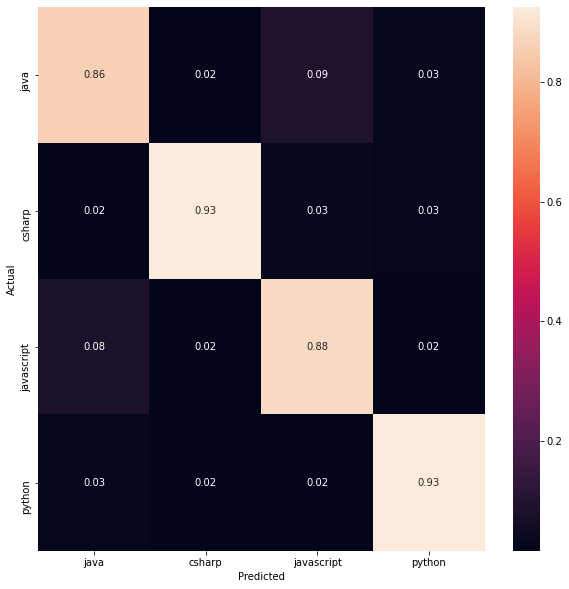

In [7]:
#!pip3 install seaborn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Normalise and Plot
target_names = ['java', 'csharp', 'javascript', 'python']
cmn = matriz_de_confusion.astype('float') / matriz_de_confusion.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)